## Test out how to edit on 2_Spurious_MNIST dataset

In [1]:
# General imports
import torch
import numpy as np
import os, sys
import json
from tqdm import tqdm
from datetime import datetime
import pandas as pd

In [2]:
# Local imports
sys.path.insert(0, 'src')
from utils import read_json, read_lists, informal_log, list_to_dict, write_lists, write_json
from utils.visualizations import show_image_rows, make_grid
from utils.model_utils import prepare_device
from parse_config import ConfigParser
# from data_loader import data_loaders
import datasets.datasets as module_data
import model.model as module_arch
from utils.knn_utils import load_and_analyze_knn
from utils.results_to_csv import store_csv
from edit_MNIST import main as edit

In [3]:
# Define constants, paths
dataset_type = '2_Spurious_MNIST'
config_path = os.path.join('configs', 'MNIST', '{}_edit.json'.format(dataset_type))
config_dict = read_json(config_path)
class_list = [i for i in range(10)]
n_hold_out_per_class = config_dict['editor']['edit_data_args']['n_hold_out_per_class']
edit_data_dir = config_dict['editor']['edit_data_args']['data_dir'].format(
    dataset_type, n_hold_out_per_class)

edit_data_path = os.path.join(edit_data_dir, 'test_hold_out_{}_eac.pt'.format(n_hold_out_per_class))
label_idx_dict_path = os.path.join(edit_data_dir, 'label_idx_dict.pt')

# edit_data = torch.load(edit_data_path)
label_idx_dict = torch.load(label_idx_dict_path)


# class_list_path = 'metadata/cinic-10/class_names.txt'

analyze_in_edit = True



In [4]:
# Load config file
config = ConfigParser(config_dict)

# Set K
K = config_dict['editor']['K']

device, device_ids = prepare_device(config_dict['n_gpu'])

In [5]:
# Load datasets
data_loader_args = dict(config_dict["data_loader"]["args"])
dataset_args = dict(config_dict["dataset"]["args"])

# Create validation data loader
dataset_args.update({"split": "test"})
test_dataset = module_data.ColoredMNIST(**dataset_args)

test_data_loader = torch.utils.data.DataLoader(
    test_dataset,
    **data_loader_args
)

# Create data loader for covariance matrix

dataset_args.update({"split": "test_hold_out_{}".format(n_hold_out_per_class)})
covariance_dataset = module_data.ColoredMNIST(**dataset_args)
covariance_data_loader = torch.utils.data.DataLoader(
    covariance_dataset,
    **data_loader_args
)


### Create log and save paths

In [6]:
# create log path to store the paths to each trial
save_root = config_dict['trainer']['save_dir']
timestamp = os.path.basename(os.path.dirname(config.save_dir))

trial_paths_path = os.path.join(save_root, config_dict['name'], timestamp, 'trial_paths.txt')
progress_report_path = os.path.join(save_root, config_dict['name'], timestamp, 'progress_report.txt')
if os.path.exists(trial_paths_path):
    print("Path {} already exists. Aborting.".format(trial_paths_path))
else:
    # progress_report_path = os.path.join(save_root, config_dict['name'], timestamp, 'progress_report.txt')
    if os.path.exists(progress_report_path):
        os.remove(progress_report_path)
    print("Saving path to directories for each trial to {}".format(trial_paths_path))
    print("Printing progress reports to {}".format(progress_report_path))

Saving path to directories for each trial to saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/trial_paths.txt
Printing progress reports to saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/progress_report.txt


### Read in idxs of selected images to use for edit

In [7]:
# Obtain list of idxs for edits
edit_idxs_filename = config_dict['editor']['edit_data_args']['edit_idxs_file']
edit_idxs_path = os.path.join(edit_data_dir, edit_idxs_filename)
edit_idxs = read_lists(edit_idxs_path)

# convert each string to list
for row_idx, row in enumerate(edit_idxs):
    row = row.split(',')
    row = [eval(i) for i in row]
    edit_idxs[row_idx] = np.array(row)

print(edit_idxs)


[array([3])]


In [8]:
# Given edit keys and values and list of idxs, return tensor of the images we want

def get_edit_pool(edit_image_pool, idxs):
    '''
    
    Arg(s):
        edit_image_pool : dict
            dictionary keyed by ['keys', 'values', 'labels', 'test_set_idxs'] (idxs is idx from test set)
            Pool of data to choose edit image from
        idxs : 1D np.array(int)
            idxs for the edit (NOT corresponding to test set idxs)
    '''
    pool_keys = edit_image_pool['keys']
    pool_values = edit_image_pool['values']
    pool_labels = edit_image_pool['labels']
    
    edit_keys = pool_keys[idxs]
    edit_values = pool_values[idxs]
    edit_labels = pool_labels[idxs]
    
    return edit_keys, edit_values, edit_labels
    
edit_pool_filename = config_dict['editor']['edit_data_args']['edit_pool_file'].format(n_hold_out_per_class)
edit_pool_path = os.path.join(edit_data_dir, edit_pool_filename)
edit_pool = torch.load(edit_pool_path)
edit_data = []

for edit_i in edit_idxs:
    edit_data.append(get_edit_pool(edit_image_pool=edit_pool, idxs=edit_i))
print(len(edit_data))


    

1


## Run edit for each modified image

In [13]:
# import data_loader.data_loaders as module_data
from predict import predict
import datasets.datasets as module_data
import model.loss as module_loss
import model.metric as module_metric
import model.model as module_arch
from trainer.editor import get_editor
from parse_config import ConfigParser
from utils.model_utils import prepare_device
from utils import read_lists
from utils.MNIST_edit_utils import prepare_edit_data_eac
from utils.knn_utils import knn, analyze_knn


# fix random seeds for reproducibility
SEED = 123
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)

def edit_MNIST(config,
         # keys,
         # values,
         # labels,
         edit_data,
         test_data_loader=None,
         covariance_data_loader=None,
         do_analyze_knn=False):
    # Obtain variables from config
    logger = config.get_logger('train')
    assert config.config['method'] == 'edit', "Invalid method '{}'. Must be 'edit'".format(config.config['method'])
    K = config.config['editor']['K']  # for KNN
    noise_edit = config.config['editor']['args']['noise_edit']
    if noise_edit:
        assert K == 0, "Cannot perform KNN analysis with random edits."

    # Determine edit method based on model type
    if 'Santurkar' in config.config['arch']['type']:
        edit_method = 'eac'
    elif 'Sinitson' in config.config['arch']['type']:
        edit_method = 'enn'

    # Store variables for if we want to perform knn analysis here
    if 'perform_analysis' in config.config['editor']:
        do_analyze_knn = config.config['editor']['perform_analysis']
    else:
        do_analyze_knn = False
    if do_analyze_knn:
        try:
            class_list_path = config.config['class_list_path']
        except:
            raise ValueError("class_list_path not in config file. Aborting")
        try:
            class_list = read_lists(class_list_path)
        except:
            raise ValueError("Unable to read file at {}. Aborting".format(class_list_path))

    save_dir = str(config.save_dir)

    # Prepare for (multi-device) GPU training
    device, device_ids = prepare_device(config['n_gpu'])

    # build model architecture, then print to console
    config.config['arch'].update()
    layernum = config.config['layernum']
    print("Editing layer {}".format(layernum))
    model = config.init_obj('arch', module_arch,
        layernum=layernum,
        device=device)
    if len(device_ids) > 1:
        model = torch.nn.DataParallel(model, device_ids=device_ids)
    model.eval()  # model should always be in eval() for editing

    logger.info("Created {} model with {} trainable parameters".format(config.config['arch']['type'], model.get_n_params()))
    model_parameters = model.get_parameters()
    optimizer = config.init_obj('optimizer', torch.optim, model_parameters)

    # Get function handles for loss and metrics
    loss_fn = getattr(module_loss, config['loss'])
    metric_fns = [getattr(module_metric, met) for met in config['metrics']]

    # Make editable
    if edit_method == 'enn':
        model.make_editable(
            loss_fn=loss_fn)

    if model.get_checkpoint_path() != "":
        logger.info("Restored weights from {}".format(model.get_checkpoint_path()))
    else:
        logger.info("Training from scratch.")

    # General arguments for data loaders
    # dataset_args = config.config['dataset_args']
    data_loader_args = config.config['data_loader']['args']

    # Provide dataloader to perform KNN and metric calculation
    if test_data_loader is None:
        test_dataset = config.init_obj('dataset', module_data)
        test_data_loader = torch.utils.data.DataLoader(
            val_data_set,
            **data_loader_args
        )
        logger.info("Created validation data loader for metric and KNN calculations")
    else:
        logger.info("Using passed in data loader for validation.")


    # Prepare data for edit
    edit_data_args = config.config['editor']['edit_data_args']
    
    # log the editor initialization arguments
    logger.info("Edit initialization arguments:")
    for key, val in edit_data_args.items():
        logger.info("{}: {}".format(key, val))
    logger.info("---***---")

    if not noise_edit:
        # edit_data = prepare_edit_data(
        #     edit_method=edit_method,
        #     **edit_data_args)
        
        # edit_data = prepare_edit_data_eac(
        #     keys=keys,
        #     values=values,
        #     labels=labels)
        '''
        If edit_method == 'enn': prepare_edit_data() returns a torch.utils.data.DataLoader
        If edit_method == 'eac': prepare_edit_data() returns a dictionary as follows:
            {
                'imgs': torch.tensor(B x C x H x W) [values]
                'modified_imgs': torch.tensor(B x C x H x W) [keys]
                'masks': torch.tensor(B x 1 x H x W) [masks]
            }
        '''

    pre_metric_save_path = os.path.join(save_dir, "pre_edit_metrics.pth")
    pre_logits_save_path = os.path.join(save_dir, "pre_edit_logits.pth")
    if K > 0:
        # Obtain anchor images
        if edit_method == 'eac':
            # for EAC, it is the key and value images
            anchor_images = torch.cat([edit_data['modified_imgs'], edit_data['imgs']], dim=0)
        elif edit_method == 'enn':
            # for ENN, it is all the edit images
            anchor_images = []
            for item in edit_data:
                images, _, _ = item
                anchor_images.append(images)
            anchor_images = torch.cat(anchor_images, dim=0)

        logger.info("Performing pre-edit metric & KNN calculations on validation set.")
        pre_edit_log = knn(
            K=K,
            data_loader=test_data_loader,
            model=model,
            anchor_image=anchor_images,
            data_types=['logits', 'images'],  # ['features', 'logits', 'images']
            metric_fns=metric_fns,
            device=device,
            save_path=None)

        # Save KNN results
        pre_knn_save_path = os.path.join(save_dir, "pre_edit_{}-nn.pth".format(K))
        torch.save(pre_edit_log['knn'], pre_knn_save_path)
        logger.info("Saved pre-edit KNN results with K={} to {}".format(K, pre_knn_save_path))
    else:  # if not performing KNN
        logger.info("Performing pre-edit metric calculations on validation set.")
        pre_edit_log = predict(
            data_loader=test_data_loader,
            model=model,
            loss_fn=loss_fn,
            metric_fns=metric_fns,
            device=device)
    # Save pre edit metrics
    logger.info("Pre-edit metrics: {}".format(pre_edit_log['metrics']))
    torch.save(pre_edit_log['metrics'], pre_metric_save_path)
    logger.info("Saved pre-edit metrics {}".format(pre_metric_save_path))
    # Save logits
    torch.save(pre_edit_log['logits'], pre_logits_save_path)
    logger.info("Saved pre-edit logits to {}".format(pre_logits_save_path))

    # Set up editor
    editor_args = config.config['editor']['args']
    if edit_method == 'eac':
        editor_args['arch'] = config.config['arch']['args']['type']
    # elif edit_method == 'enn':
    #     editor_args.update({
    #         'model': model,
    #         'optimizer': optimizer,
    #         'loss_fn': loss_fn,
    #         })
    #     if 'error' in editor_args:
    #         editor_args.pop('error')
    #         editor_args['error_fn'] = None

    editor = get_editor(
        edit_method=edit_method,
        **editor_args)

    logger.info("Created {} editor.".format(type(editor)))

    # Prepare covariance dataset if necessary
    if not noise_edit:
        if edit_method == 'eac':
            if covariance_data_loader is None:
                if 'covariance_dataset' in config.config and 'images' in config.config['covariance_dataset']:
                    # Always use the dummy val_data_loader for covariance calculation
                    covariance_image_paths = read_lists(config.config['covariance_dataset']['images'])
                    covariance_labels = read_lists(config.config['covariance_dataset']['labels'])

                    covariance_data_loader = torch.utils.data.DataLoader(
                        module_data.CINIC10Dataset(
                            data_dir="",
                            image_paths=covariance_image_paths,
                            labels=covariance_labels,
                            return_paths=False,
                            **dataset_args
                        ),
                        **data_loader_args
                    )
                    val_data_name = config.config['covariance_dataset']['name']

                    logger.info("Created dataloader for covariance matrix from {}".format(config.config['covariance_dataset']['images']))
                else:  # Use identity matrix
                    covariance_data_loader = None
                    val_data_name = "identity"
                    logger.info("No data loader for covariance matrix. Will use identity matrix")
            else:
                val_data_name = config.config['covariance_dataset']['name']
                logger.info("Using passed in covariance data loader.")
    else:
        logger.info("Performing random edit. No covariance matrix needed.")

    # Perform edit
    if not noise_edit:
        if edit_method == 'eac':
            # Create path for caching directory based on
            #   (1) validation data dir
            #   (2) context model -- architecture, layer number
            model_arch = model.get_type()
            cache_dir = os.path.join('cache', val_data_name, "{}-{}".format(model_arch, layernum))
            logger.info("Looking for covariance matrix weights in {}".format(cache_dir))
            editor.edit(
                edit_data=edit_data,
                model=model,
                val_data_loader=covariance_data_loader,
                cache_dir=cache_dir)
        elif edit_method == 'enn':
            edit_results_save_path = os.path.join(save_dir, "edit_results.pth")
            edit_images, edit_labels = edit_data
            edited_model, edit_results = editor.edit(
                model=model,
                inputs=edit_images,
                targets=edit_labels,
                save_path=edit_results_save_path
            )
            logger.info("Edit results from ENN: {}".format(edit_results))
            model.model = edited_model

    else:
        editor.noise_edit(
            model=model
        )

    if not do_analyze_knn and not noise_edit:
        model.save_model(save_path=os.path.join(save_dir, "edited_model.pth"))

    # Perform post edit KNN analysis
    post_metric_save_path = os.path.join(save_dir, "post_edit_metrics.pth")
    post_logits_save_path = os.path.join(save_dir, "post_edit_logits.pth")
    if K > 0:
        # Concatenate key and value images together

        logger.info("Performing post-edit metric & KNN calculations on validation set.")

        post_edit_log = knn(
            K=K,
            data_loader=test_data_loader,
            model=model,
            anchor_image=anchor_images,
            data_types=['features', 'logits', 'images'],
            metric_fns=metric_fns,
            device=device,
            save_path=None)

        logger.info("Post-edit metrics: {}".format(post_edit_log['metrics']))
        # Save metrics
        # post_metric_save_path = os.path.join(save_dir, "post_edit_metrics.pth")
        # torch.save(post_edit_log['metrics'], post_metric_save_path)
        # logger.info("Saved post-edit metrics to {}".format(post_metric_save_path))
        # Save KNN results
        post_knn_save_path = os.path.join(save_dir, "post_edit_{}-nn.pth".format(K))
        torch.save(post_edit_log['knn'], post_knn_save_path)
        logger.info("Saving post-edit KNN results with K={} to {}".format(K, post_knn_save_path))
        # Save logits
        # torch.save(post_edit_log['logits'], post_logits_save_path)
        # logger.info("Saved post-edit logits to {}".format(post_logits_save_path))
    else:  # if not performing KNN
        logger.info("Performing post-edit metric calculations on validation set.")

        post_edit_log = predict(
            data_loader=test_data_loader,
            model=model,
            loss_fn=loss_fn,
            metric_fns=metric_fns,
            device=device)

    logger.info("Post-edit metrics: {}".format(post_edit_log['metrics']))
    # Save post edit metrics
    torch.save(post_edit_log['metrics'], post_metric_save_path)
    logger.info("Saved post-edit metrics {}".format(post_metric_save_path))
    # Save post edit logits
    torch.save(post_edit_log['logits'], post_logits_save_path)
    logger.info("Saved post-edit logits to {}".format(post_logits_save_path))

    # Analyze KNN results here and now
    if do_analyze_knn and K > 0:
        logger.info("Performing KNN analysis...")
        target_class_idx = np.argmax(post_edit_log['knn']['logits']['anchor_data'][0])
        analyze_knn(
            save_dir=save_dir,
            config=config,
            pre_edit_knn=pre_edit_log['knn'],
            post_edit_knn=post_edit_log['knn'],
            edited_model=model,
            knn_analysis_filename='knn_analysis_results.pth',
            target_class_idx=target_class_idx,
            class_list=class_list,
            progress_report_path=None,
            save_plots=True)

    logger.info("All metrics and KNN results can be found in {}".format(save_dir))

In [14]:
def run_trials(edit_data: list,
               progress_report_path: str,
               trial_paths_path: str,
               # timestamp: str,
               config_dict: dict,
               run_id_prefix: str="",
               debug=True): 
    
    n_trials = len(edit_data)
    
    for idx, cur_edit_data in enumerate(edit_data):
        informal_log("({}) Starting Trial {}/{}...".format(
            datetime.now().strftime(r'%m%d_%H%M%S'), 
            idx + 1, n_trials), 
            progress_report_path)
        run_id = os.path.join(run_id_prefix, 'results', 'edit_idx_{}'.format(idx))

        config = ConfigParser(config_dict, run_id=run_id)
        
        trial_save_dir = config.save_dir
        cur_trial_path = os.path.dirname(trial_save_dir)

        informal_log(cur_trial_path, trial_paths_path)
        edit_data_save_path = os.path.join(trial_save_dir, 'edit_data.pt')
        # key_save_path = os.path.join(trial_save_dir, 'keys.pt')
        # value_save_path =os.path.join(trial_save_dir, 'values.pt')
        keys, values, labels = cur_edit_data
        trial_edit_data = prepare_edit_data_eac(
                keys=keys,
                values=values,
                labels=labels)

        torch.save(trial_edit_data, edit_data_save_path)
        print(trial_edit_data['masks'].dtype)
        trial_edit_data['masks'] = trial_edit_data['masks'].to(torch.int32)
        if debug:
            show_image_rows(
                images=[np.concatenate([trial_edit_data['modified_imgs'], trial_edit_data['imgs'], trial_edit_data['masks'].repeat(1, 3, 1, 1)], axis=0)],
                # images=[np.concatenate([trial_edit_data['modified_imgs'], trial_edit_data['imgs'], trial_edit_data['masks']], axis=0)],
                image_titles=[['key', 'value', 'mask']])
        edit_MNIST(
            config=config,
            test_data_loader=test_data_loader,
            covariance_data_loader=covariance_data_loader,
            edit_data=trial_edit_data,
            do_analyze_knn=analyze_in_edit)

In [17]:
def run_experiments(iv_name: str,
                    iv_values: list,
                    edit_data: list,
                    progress_report_path: str,
                    trial_paths_path: str,
                    timestamp: str,
                    config_dict: dict,
                    debug=True):
    
    assert iv_name in config_dict.keys()
    n_experiments = len(iv_values)
    for iv_idx, iv_value in enumerate(iv_values):
        config_dict[iv_name] = iv_value
        informal_log("Experimenting with {} of {}".format(iv_name, iv_value), progress_report_path)
        
        run_id_prefix = os.path.join(timestamp, '{}_{}'.format(iv_name, iv_value))
        run_trials(
            edit_data=edit_data,
            progress_report_path=progress_report_path,
            trial_paths_path=trial_paths_path,
            config_dict=config_dict,
            run_id_prefix=run_id_prefix,
            debug=debug)
            

#### Run experiments varying layer number

Varying layernum with following values: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Experimenting with layernum of 1
(0320_111959) Starting Trial 1/1...
saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_1/results/edit_idx_0
torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.float32


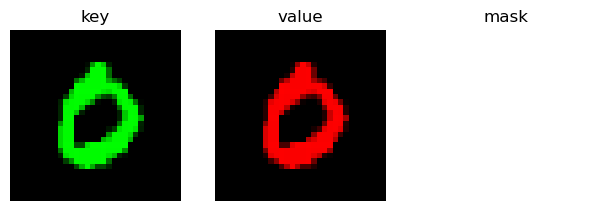

Editing layer 1
Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 26.06it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_1/results/edit_idx_0/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/vgg16_bn-1
Computing cov matrices...


100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.52it/s]


acts shape: torch.Size([256, 64, 32, 32])
acts shape: torch.Size([244, 64, 32, 32])
Cov shape: torch.Size([64, 64])


tensor(1.0251, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:53<00:00, 752.5


Loss (orig, final): 0.43151694536209106 1.025132656097412
L2 norm of weight change: 40.20195007324219
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.16it/s]

Post-edit metrics: {'TP': array([448, 534, 611, 844, 453,  69, 116,  90, 134,  41]), 'TN': array([8366, 8397, 8112, 4626, 7874, 8606, 8510, 8462, 7867, 8520]), 'FPs': array([ 204,   18,  406, 3914,  694,   52,   82,   60,  709,   21]), 'FNs': array([482, 551, 371, 116, 479, 773, 792, 888, 790, 918]), 'accuracy': 0.35157894736842105, 'per_class_accuracy': array([0.92778947, 0.94010526, 0.91821053, 0.57578947, 0.87652632,
       0.91315789, 0.908     , 0.90021053, 0.84221053, 0.90115789]), 'per_class_accuracy_mean': 0.8703157894736842, 'precision': array([0.68711656, 0.9673913 , 0.60078663, 0.17738546, 0.39494333,
       0.57024793, 0.58585859, 0.6       , 0.15895611, 0.66129032]), 'precision_mean': 0.5403976234059058, 'recall': array([0.48172043, 0.4921659 , 0.62219959, 0.87916667, 0.4860515 ,
       0.08194774, 0.1277533 , 0.09202454, 0.14502165, 0.04275287]), 'recall_mean': 0.34508041901076747, 'predicted_class_distribution': array([ 652,  552, 1017, 4758, 1147,  121,  198,  150,  843

Saved post-edit logits to saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_1/results/edit_idx_0/models/post_edit_logits.pth
All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_1/results/edit_idx_0/models
Experimenting with layernum of 2
(0320_112058) Starting Trial 1/1...
saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_2/results/edit_idx_0
torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.float32


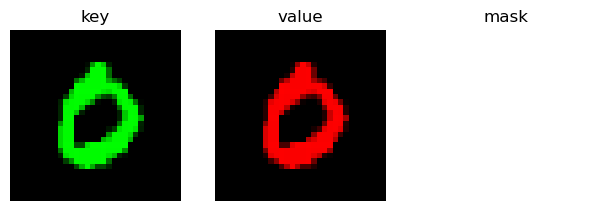

Editing layer 2
Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.67it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_2/results/edit_idx_0/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/vgg16_bn-2
Computing cov matrices...


100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.23it/s]


acts shape: torch.Size([256, 64, 16, 16])
acts shape: torch.Size([244, 64, 16, 16])
Cov shape: torch.Size([64, 64])


tensor(0.3055, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:45<00:00, 870.6


Loss (orig, final): 0.3500983417034149 0.3054737448692322
L2 norm of weight change: 19.457849502563477
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.89it/s]


Post-edit metrics: {'TP': array([464, 539, 638, 502, 513, 411, 268, 412, 297, 204]), 'TN': array([8342, 8390, 7966, 7381, 7811, 7264, 8561, 7940, 8176, 8417]), 'FPs': array([ 228,   25,  552, 1159,  757, 1394,   31,  582,  400,  124]), 'FNs': array([466, 546, 344, 458, 419, 431, 640, 566, 627, 755]), 'accuracy': 0.4471578947368421, 'per_class_accuracy': array([0.92694737, 0.93989474, 0.90568421, 0.82978947, 0.87621053,
       0.80789474, 0.92936842, 0.87915789, 0.89189474, 0.90747368]), 'per_class_accuracy_mean': 0.8894315789473686, 'precision': array([0.67052023, 0.95567376, 0.53613445, 0.30222757, 0.40393701,
       0.22770083, 0.89632107, 0.41448692, 0.42611191, 0.62195122]), 'precision_mean': 0.5455064975963722, 'recall': array([0.49892473, 0.49677419, 0.6496945 , 0.52291667, 0.55042918,
       0.48812352, 0.29515419, 0.42126789, 0.32142857, 0.21272158]), 'recall_mean': 0.4457435027500454, 'predicted_class_distribution': array([ 692,  564, 1190, 1661, 1270, 1805,  299,  994,  697, 

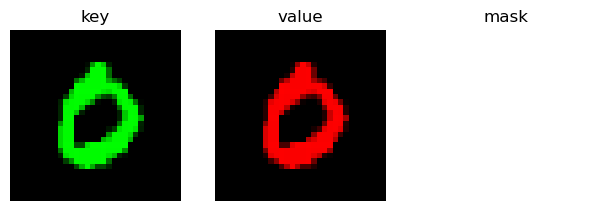

Editing layer 3
Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.71it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_3/results/edit_idx_0/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/vgg16_bn-3
Computing cov matrices...


100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.19it/s]


acts shape: torch.Size([256, 128, 16, 16])
acts shape: torch.Size([244, 128, 16, 16])
Cov shape: torch.Size([128, 128])


tensor(0.5285, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:54<00:00, 733.2


Loss (orig, final): 0.5816529989242554 0.5285232663154602
L2 norm of weight change: 18.56880760192871
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.12it/s]

Post-edit metrics: {'TP': array([448, 534, 587, 511, 451, 358, 333, 388, 444, 303]), 'TN': array([8382, 8404, 8069, 7246, 7855, 8089, 8530, 8270, 7193, 8319]), 'FPs': array([ 188,   11,  449, 1294,  713,  569,   62,  252, 1383,  222]), 'FNs': array([482, 551, 395, 449, 481, 484, 575, 590, 480, 656]), 'accuracy': 0.45863157894736845, 'per_class_accuracy': array([0.92947368, 0.94084211, 0.91115789, 0.81652632, 0.87431579,
       0.88915789, 0.93294737, 0.91136842, 0.80389474, 0.90757895]), 'per_class_accuracy_mean': 0.8917263157894737, 'precision': array([0.70440252, 0.97981651, 0.56660232, 0.28310249, 0.38745704,
       0.38619202, 0.84303797, 0.60625   , 0.24302135, 0.57714286]), 'precision_mean': 0.5577025079391389, 'recall': array([0.48172043, 0.4921659 , 0.59775967, 0.53229167, 0.48390558,
       0.42517815, 0.36674009, 0.39672802, 0.48051948, 0.31595412]), 'recall_mean': 0.4572963100052627, 'predicted_class_distribution': array([ 636,  545, 1036, 1805, 1164,  927,  395,  640, 1827,

Saved post-edit metrics saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_3/results/edit_idx_0/models/post_edit_metrics.pth
Saved post-edit logits to saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_3/results/edit_idx_0/models/post_edit_logits.pth
All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_3/results/edit_idx_0/models
Experimenting with layernum of 4
(0320_112250) Starting Trial 1/1...
saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_4/results/edit_idx_0
torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.float32


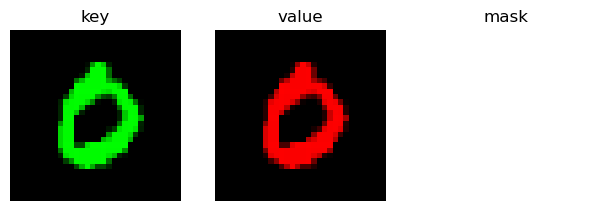

Editing layer 4
Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.87it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_4/results/edit_idx_0/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/vgg16_bn-4
Computing cov matrices...


100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.91it/s]


acts shape: torch.Size([256, 128, 8, 8])
acts shape: torch.Size([244, 128, 8, 8])
Cov shape: torch.Size([128, 128])


tensor(0.2477, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:53<00:00, 752.1


Loss (orig, final): 0.4418451488018036 0.24772359430789948
L2 norm of weight change: 13.6729736328125
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 24.76it/s]

Post-edit metrics: {'TP': array([447, 540, 534, 499, 450, 418, 434, 473, 455, 439]), 'TN': array([8334, 8383, 8150, 7455, 7924, 8277, 8371, 7933, 7764, 8098]), 'FPs': array([ 236,   32,  368, 1085,  644,  381,  221,  589,  812,  443]), 'FNs': array([483, 545, 448, 461, 482, 424, 474, 505, 469, 520]), 'accuracy': 0.49357894736842106, 'per_class_accuracy': array([0.92431579, 0.93926316, 0.91410526, 0.83726316, 0.88147368,
       0.91526316, 0.92684211, 0.88484211, 0.86515789, 0.89863158]), 'per_class_accuracy_mean': 0.8987157894736842, 'precision': array([0.65446559, 0.94405594, 0.59201774, 0.31502525, 0.41133455,
       0.52315394, 0.66259542, 0.44538606, 0.35911602, 0.49773243]), 'precision_mean': 0.5404882954723754, 'recall': array([0.48064516, 0.49769585, 0.54378819, 0.51979167, 0.48283262,
       0.49643705, 0.47797357, 0.48364008, 0.49242424, 0.45776851]), 'recall_mean': 0.4932996941891011, 'predicted_class_distribution': array([ 683,  572,  902, 1584, 1094,  799,  655, 1062, 1267,

Saved post-edit logits to saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_4/results/edit_idx_0/models/post_edit_logits.pth
All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_4/results/edit_idx_0/models
Experimenting with layernum of 5
(0320_112349) Starting Trial 1/1...
saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_5/results/edit_idx_0
torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.float32


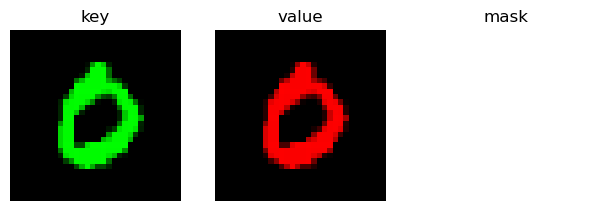

Editing layer 5
Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.34it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_5/results/edit_idx_0/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/vgg16_bn-5
Computing cov matrices...


100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.51it/s]


acts shape: torch.Size([256, 256, 8, 8])
acts shape: torch.Size([244, 256, 8, 8])
Cov shape: torch.Size([256, 256])


tensor(0.2612, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:47<00:00, 837.8


Loss (orig, final): 0.4606877565383911 0.26116523146629333
L2 norm of weight change: 17.96846580505371
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.33it/s]

Post-edit metrics: {'TP': array([448, 535, 527, 498, 451, 417, 436, 470, 454, 444]), 'TN': array([8358, 8389, 8155, 7481, 7873, 8314, 8408, 8023, 7561, 8118]), 'FPs': array([ 212,   26,  363, 1059,  695,  344,  184,  499, 1015,  423]), 'FNs': array([482, 550, 455, 462, 481, 425, 472, 508, 470, 515]), 'accuracy': 0.4926315789473684, 'per_class_accuracy': array([0.92694737, 0.93936842, 0.91389474, 0.83989474, 0.87621053,
       0.91905263, 0.93094737, 0.894     , 0.84368421, 0.90126316]), 'per_class_accuracy_mean': 0.8985263157894737, 'precision': array([0.67878788, 0.95365419, 0.59213483, 0.31984586, 0.39354276,
       0.54796321, 0.70322581, 0.48503612, 0.30905378, 0.51211073]), 'precision_mean': 0.5495355151226146, 'recall': array([0.48172043, 0.49308756, 0.53665988, 0.51875   , 0.48390558,
       0.49524941, 0.48017621, 0.4805726 , 0.49134199, 0.46298227]), 'recall_mean': 0.49244459242205363, 'predicted_class_distribution': array([ 660,  561,  890, 1557, 1146,  761,  620,  969, 1469,

Saved post-edit logits to saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_5/results/edit_idx_0/models/post_edit_logits.pth
All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_5/results/edit_idx_0/models
Experimenting with layernum of 6
(0320_112442) Starting Trial 1/1...
saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_6/results/edit_idx_0
torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.float32


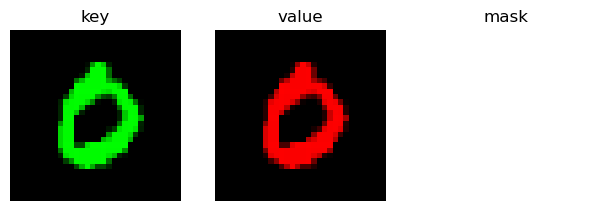

Editing layer 6
Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.45it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':


100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.21it/s]


acts shape: torch.Size([256, 256, 8, 8])
acts shape: torch.Size([244, 256, 8, 8])
Cov shape: torch.Size([256, 256])


tensor(0.2498, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:45<00:00, 870.6


Loss (orig, final): 0.7345532178878784 0.24975326657295227
L2 norm of weight change: 21.191837310791016
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.69it/s]

Post-edit metrics: {'TP': array([447, 549, 525, 499, 453, 419, 434, 463, 452, 443]), 'TN': array([8316, 8387, 8084, 7445, 8006, 8307, 8316, 7992, 7852, 7979]), 'FPs': array([ 254,   28,  434, 1095,  562,  351,  276,  530,  724,  562]), 'FNs': array([483, 536, 457, 461, 479, 423, 474, 515, 472, 516]), 'accuracy': 0.49305263157894735, 'per_class_accuracy': array([0.92242105, 0.94063158, 0.90621053, 0.83621053, 0.89042105,
       0.91852632, 0.92105263, 0.89      , 0.87410526, 0.88652632]), 'per_class_accuracy_mean': 0.8986105263157895, 'precision': array([0.63766049, 0.95147314, 0.54744526, 0.31304893, 0.44630542,
       0.54415584, 0.61126761, 0.46626385, 0.38435374, 0.44079602]), 'precision_mean': 0.534277028774601, 'recall': array([0.48064516, 0.50599078, 0.53462322, 0.51979167, 0.4860515 ,
       0.4976247 , 0.47797357, 0.47341513, 0.48917749, 0.46193952]), 'recall_mean': 0.4927232745240987, 'predicted_class_distribution': array([ 701,  577,  959, 1594, 1015,  770,  710,  993, 1176, 

Saved post-edit logits to saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_6/results/edit_idx_0/models/post_edit_logits.pth
All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_6/results/edit_idx_0/models
Experimenting with layernum of 7
(0320_112534) Starting Trial 1/1...
saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_7/results/edit_idx_0
torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.float32


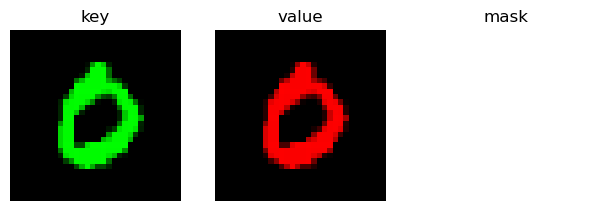

Editing layer 7
Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 19.91it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Saved pre-edit metrics saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_7/results/edit_idx_0/models/pre_edit_metrics.pth
Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_7/results/edit_idx_0/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/vgg16_bn-7
Computing cov matrices...


  0%|                                                                     | 0/2 [00:00<?, ?it/s]

acts shape: torch.Size([256, 256, 4, 4])
acts shape: torch.Size([244, 256, 4, 4])


100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.95it/s]


Cov shape: torch.Size([256, 256])


tensor(0.1202, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:47<00:00, 840.8


Loss (orig, final): 0.4494945704936981 0.12021812796592712
L2 norm of weight change: 14.58079719543457
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.28it/s]

Post-edit metrics: {'TP': array([446, 535, 522, 499, 452, 418, 436, 471, 453, 453]), 'TN': array([8296, 8383, 8221, 7495, 7859, 8237, 8395, 7933, 7829, 8037]), 'FPs': array([ 274,   32,  297, 1045,  709,  421,  197,  589,  747,  504]), 'FNs': array([484, 550, 460, 461, 480, 424, 472, 507, 471, 506]), 'accuracy': 0.49315789473684213, 'per_class_accuracy': array([0.92021053, 0.93873684, 0.92031579, 0.84147368, 0.87484211,
       0.91105263, 0.92957895, 0.88463158, 0.87178947, 0.89368421]), 'per_class_accuracy_mean': 0.8986315789473682, 'precision': array([0.61944444, 0.94356261, 0.63736264, 0.32318653, 0.38931955,
       0.49821216, 0.68878357, 0.44433962, 0.3775    , 0.47335423]), 'precision_mean': 0.5395065354890762, 'recall': array([0.47956989, 0.49308756, 0.53156823, 0.51979167, 0.48497854,
       0.49643705, 0.48017621, 0.48159509, 0.49025974, 0.47236705]), 'recall_mean': 0.49298310330011486, 'predicted_class_distribution': array([ 720,  567,  819, 1544, 1161,  839,  633, 1060, 1200

Experimenting with layernum of 8
(0320_112628) Starting Trial 1/1...
saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_8/results/edit_idx_0
torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.float32


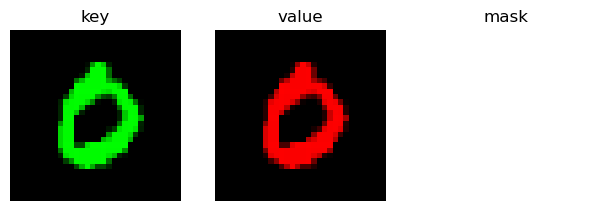

Editing layer 8
Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.49it/s]


Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.85it/s]


acts shape: torch.Size([256, 512, 4, 4])
acts shape: torch.Size([244, 512, 4, 4])
Cov shape: torch.Size([512, 512])


tensor(0.1213, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:48<00:00, 833.0


Loss (orig, final): 0.46922212839126587 0.1213349848985672
L2 norm of weight change: 17.934560775756836
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.38it/s]

Post-edit metrics: {'TP': array([448, 537, 520, 498, 452, 422, 438, 471, 456, 452]), 'TN': array([8292, 8383, 8189, 7569, 7822, 8240, 8396, 7980, 7807, 8016]), 'FPs': array([278,  32, 329, 971, 746, 418, 196, 542, 769, 525]), 'FNs': array([482, 548, 462, 462, 480, 420, 470, 507, 468, 507]), 'accuracy': 0.4941052631578947, 'per_class_accuracy': array([0.92      , 0.93894737, 0.91673684, 0.84915789, 0.87094737,
       0.91178947, 0.92989474, 0.88957895, 0.86978947, 0.89136842]), 'per_class_accuracy_mean': 0.898821052631579, 'precision': array([0.61707989, 0.94376098, 0.61248528, 0.33900613, 0.37729549,
       0.50238095, 0.69085174, 0.46495558, 0.3722449 , 0.46264074]), 'precision_mean': 0.5382701669688748, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.50118765, 0.48237885, 0.48159509, 0.49350649, 0.4713243 ]), 'recall_mean': 0.49399037994386574, 'predicted_class_distribution': array([ 726,  569,  849, 1469, 1198,  840,  634, 1013, 1225,  977]), 'f

Saved post-edit metrics saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_8/results/edit_idx_0/models/post_edit_metrics.pth
Saved post-edit logits to saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_8/results/edit_idx_0/models/post_edit_logits.pth
All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_8/results/edit_idx_0/models
Experimenting with layernum of 9
(0320_112722) Starting Trial 1/1...
saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_9/results/edit_idx_0
torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.float32


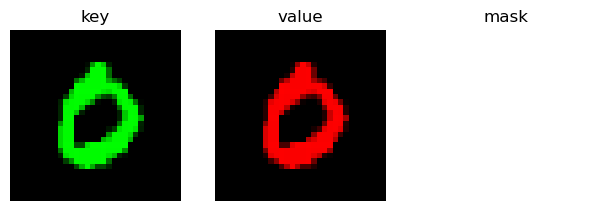

Editing layer 9
Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.55it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Saved pre-edit metrics saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_9/results/edit_idx_0/models/pre_edit_metrics.pth
Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_9/results/edit_idx_0/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/vgg16_bn-9
Computing cov matrices...


100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.23it/s]


acts shape: torch.Size([256, 512, 4, 4])
acts shape: torch.Size([244, 512, 4, 4])
Cov shape: torch.Size([512, 512])


tensor(0.0889, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:50<00:00, 790.5


Loss (orig, final): 0.7996953725814819 0.08889714628458023
L2 norm of weight change: 16.00735092163086
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.07it/s]


Post-edit metrics: {'TP': array([448, 537, 521, 499, 452, 423, 437, 473, 455, 454]), 'TN': array([8302, 8379, 8189, 7579, 7808, 8206, 8402, 7918, 7896, 8020]), 'FPs': array([268,  36, 329, 961, 760, 452, 190, 604, 680, 521]), 'FNs': array([482, 548, 461, 461, 480, 419, 471, 505, 469, 505]), 'accuracy': 0.4946315789473684, 'per_class_accuracy': array([0.92105263, 0.93852632, 0.91684211, 0.85031579, 0.86947368,
       0.90831579, 0.93042105, 0.88326316, 0.87905263, 0.892     ]), 'per_class_accuracy_mean': 0.8989263157894737, 'precision': array([0.62569832, 0.93717277, 0.61294118, 0.34178082, 0.37293729,
       0.48342857, 0.6969697 , 0.43918292, 0.40088106, 0.46564103]), 'precision_mean': 0.5376633657823278, 'recall': array([0.48172043, 0.49493088, 0.5305499 , 0.51979167, 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49242424, 0.4734098 ]), 'recall_mean': 0.4945098367342319, 'predicted_class_distribution': array([ 716,  573,  850, 1460, 1212,  875,  627, 1077, 1135,  975]), 'f

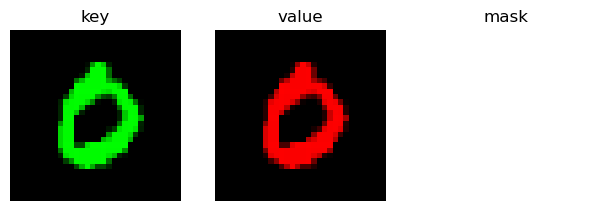

Editing layer 10
Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.46it/s]


Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.34it/s]


acts shape: torch.Size([256, 512, 2, 2])
acts shape: torch.Size([244, 512, 2, 2])
Cov shape: torch.Size([512, 512])


tensor(0.1013, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:48<00:00, 831.3


Loss (orig, final): 0.44414475560188293 0.10128232091665268
L2 norm of weight change: 4.643538951873779
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 24.90it/s]


Post-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 436, 474, 454, 454]), 'TN': array([8329, 8375, 8210, 7550, 7791, 8236, 8396, 7914, 7874, 8021]), 'FPs': array([241,  40, 308, 990, 777, 422, 196, 608, 702, 520]), 'FNs': array([482, 548, 462, 462, 480, 419, 472, 504, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92389474, 0.93810526, 0.91894737, 0.84715789, 0.86768421,
       0.91147368, 0.92968421, 0.88294737, 0.87663158, 0.89210526]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.65021771, 0.93067591, 0.62801932, 0.33467742, 0.36777868,
       0.50059172, 0.68987342, 0.43807763, 0.39273356, 0.4661191 ]), 'precision_mean': 0.5398764469813688, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48017621, 0.48466258, 0.49134199, 0.4734098 ]), 'recall_mean': 0.49418772929561233, 'predicted_class_distribution': array([ 689,  577,  828, 1488, 1229,  845,  632, 1082, 1156,  974]), '

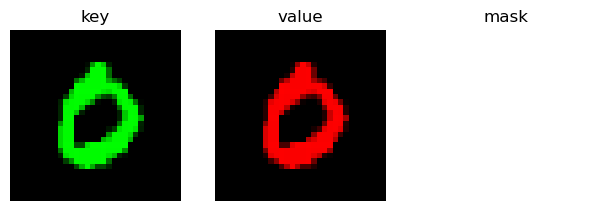

Editing layer 11
Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 24.98it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':


100%|█████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 15.58it/s]


acts shape: torch.Size([256, 512, 2, 2])
acts shape: torch.Size([244, 512, 2, 2])
Cov shape: torch.Size([512, 512])


tensor(0.1180, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:48<00:00, 824.5


Loss (orig, final): 0.47850504517555237 0.11796461045742035
L2 norm of weight change: 4.58345365524292
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 24.84it/s]

Post-edit metrics: {'TP': array([447, 537, 520, 498, 452, 422, 437, 473, 454, 454]), 'TN': array([8327, 8377, 8213, 7552, 7785, 8239, 8398, 7916, 7872, 8015]), 'FPs': array([243,  38, 305, 988, 783, 419, 194, 606, 704, 526]), 'FNs': array([483, 548, 462, 462, 480, 420, 471, 505, 470, 505]), 'accuracy': 0.4941052631578947, 'per_class_accuracy': array([0.92357895, 0.93831579, 0.91926316, 0.84736842, 0.86705263,
       0.91168421, 0.93      , 0.88305263, 0.87642105, 0.89147368]), 'per_class_accuracy_mean': 0.898821052631579, 'precision': array([0.64782609, 0.93391304, 0.63030303, 0.33512786, 0.3659919 ,
       0.50178359, 0.69255151, 0.43836886, 0.39205527, 0.46326531]), 'precision_mean': 0.5401186453989621, 'recall': array([0.48064516, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.50118765, 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.493969320238124, 'predicted_class_distribution': array([ 690,  575,  825, 1486, 1235,  841,  631, 1079, 1158,  980]), 'f1'

Saved post-edit logits to saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_11/results/edit_idx_0/models/post_edit_logits.pth
All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_11/results/edit_idx_0/models
Experimenting with layernum of 12
(0320_113014) Starting Trial 1/1...
saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_12/results/edit_idx_0
torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.float32


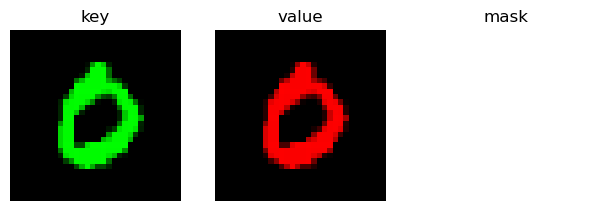

Editing layer 12
Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.56it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Saved pre-edit metrics saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_12/results/edit_idx_0/models/pre_edit_metrics.pth
Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_12/results/edit_idx_0/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.1473, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 40000/40000 [00:49<00:00, 814.6


Loss (orig, final): 1.2179887294769287 0.14726069569587708
L2 norm of weight change: 4.148594379425049
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.46it/s]

Post-edit metrics: {'TP': array([448, 537, 520, 498, 452, 422, 436, 473, 454, 454]), 'TN': array([8317, 8376, 8213, 7561, 7788, 8237, 8376, 7919, 7885, 8022]), 'FPs': array([253,  39, 305, 979, 780, 421, 216, 603, 691, 519]), 'FNs': array([482, 548, 462, 462, 480, 420, 472, 505, 470, 505]), 'accuracy': 0.4941052631578947, 'per_class_accuracy': array([0.92263158, 0.93821053, 0.91926316, 0.84831579, 0.86736842,
       0.91147368, 0.92757895, 0.88336842, 0.87778947, 0.89221053]), 'per_class_accuracy_mean': 0.898821052631579, 'precision': array([0.63908702, 0.93229167, 0.63030303, 0.33716994, 0.36688312,
       0.50059312, 0.66871166, 0.43959108, 0.39650655, 0.46659815]), 'precision_mean': 0.5377735326051984, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.50118765, 0.48017621, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4939667149612541, 'predicted_class_distribution': array([ 701,  576,  825, 1477, 1232,  843,  652, 1076, 1145,  973]), 'f1

Saved post-edit logits to saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_12/results/edit_idx_0/models/post_edit_logits.pth
All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/VGG_16-layernum/0320_111512/layernum_12/results/edit_idx_0/models


In [18]:
iv_name = 'layernum'
iv_values = [i for i in range(1, 13)]
print("Varying {} with following values: {}".format(iv_name, iv_values))

run_experiments(
    iv_name=iv_name,
    iv_values=iv_values,
    edit_data=edit_data,
    progress_report_path=progress_report_path,
    trial_paths_path=trial_paths_path,
    timestamp=timestamp,
    config_dict=config_dict,
    debug=True)

(0320_093934) Starting Trial 1/9...
***
0320_092443/results/edit_idx_0
saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_0/models
saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_0
saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_0
torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.int64


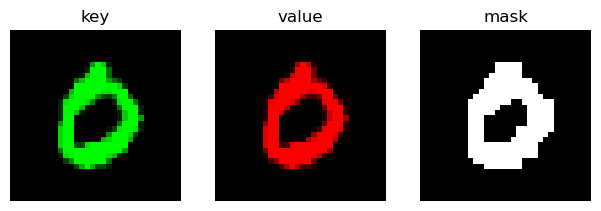

Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.34it/s]


Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

tensor(0.5405, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 10000/10000 [00:12<00:00, 791.3


Loss (orig, final): 1.2179887294769287 0.5404833555221558
L2 norm of weight change: 0.0
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.45it/s]

Post-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1'

***
0320_092443/results/edit_idx_1
saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_1/models
saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_1
saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_1
torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.int64


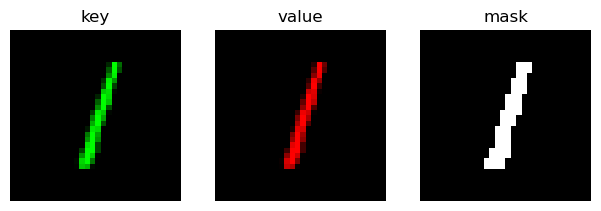

Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.68it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Found precomputed cov matrices, returning...


tensor(0.2592, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 10000/10000 [00:12<00:00, 800.6


Loss (orig, final): 0.8326869010925293 0.2592006325721741
L2 norm of weight change: 0.0
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 26.33it/s]


Post-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1'

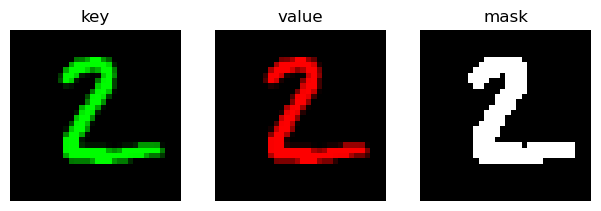

Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.40it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Found precomputed cov matrices, returning...


tensor(0.3559, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 10000/10000 [00:11<00:00, 875.7


Loss (orig, final): 0.9827195405960083 0.3559204339981079
L2 norm of weight change: 0.0
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 26.01it/s]

Post-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1'

***
0320_092443/results/edit_idx_3
saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_3/models
saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_3
saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_3
torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.int64


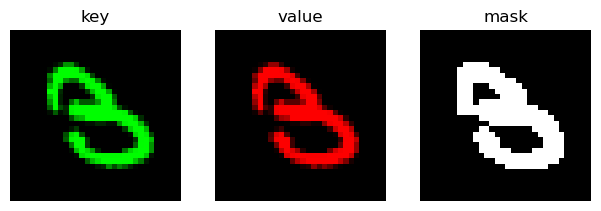

Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.19it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Found precomputed cov matrices, returning...


tensor(0.3774, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 10000/10000 [00:12<00:00, 793.3


Loss (orig, final): 1.051389455795288 0.3773579001426697
L2 norm of weight change: 0.0
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.56it/s]


Post-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1'

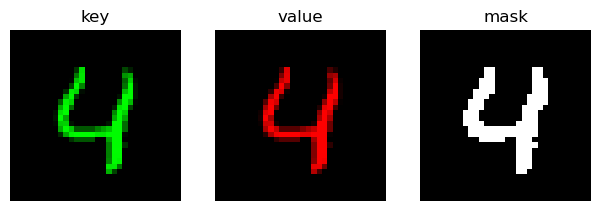

Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.58it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Saved pre-edit metrics saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_4/models/pre_edit_metrics.pth
Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_4/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.4981, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 10000/10000 [00:11<00:00, 845.4


Loss (orig, final): 1.193426489830017 0.4981410503387451
L2 norm of weight change: 0.0
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.34it/s]


Post-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1'

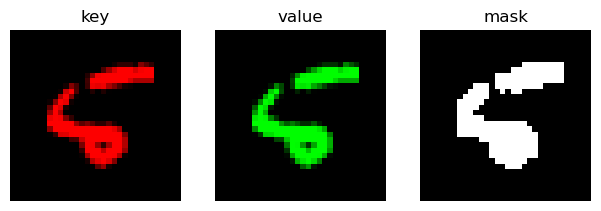

Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.43it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Found precomputed cov matrices, returning...


tensor(0.3022, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 10000/10000 [00:12<00:00, 791.7


Loss (orig, final): 0.9471166729927063 0.30217617750167847
L2 norm of weight change: 0.0
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.59it/s]

Post-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1'

Saved post-edit metrics saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_5/models/post_edit_metrics.pth
Saved post-edit logits to saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_5/models/post_edit_logits.pth
All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_5/models
(0320_094117) Starting Trial 7/9...
***
0320_092443/results/edit_idx_6
saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_6/models
saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_6
saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_6
torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.int64


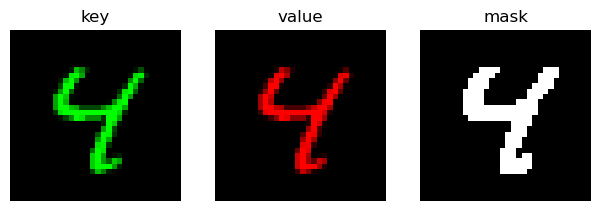

Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 26.01it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Found precomputed cov matrices, returning...


tensor(0.4212, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 10000/10000 [00:11<00:00, 859.9


Loss (orig, final): 1.1168369054794312 0.4211982190608978
L2 norm of weight change: 0.0
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.52it/s]

Post-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1'

***
0320_092443/results/edit_idx_7
saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_7/models
saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_7
saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_7
torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.int64


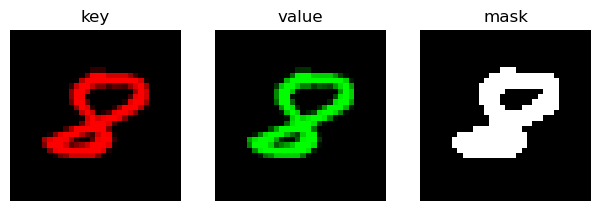

Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.21it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Saved pre-edit metrics saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_7/models/pre_edit_metrics.pth
Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_7/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.3574, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 10000/10000 [00:11<00:00, 875.1


Loss (orig, final): 1.0344688892364502 0.3573950529098511
L2 norm of weight change: 0.0
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.68it/s]


Post-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1'

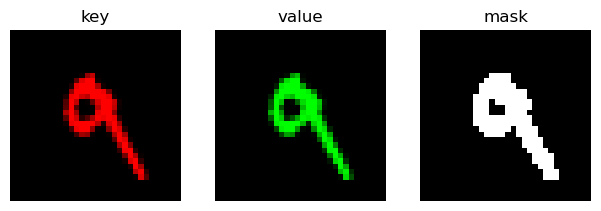

Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.59it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Found precomputed cov matrices, returning...


tensor(0.3607, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 10000/10000 [00:12<00:00, 794.5


Loss (orig, final): 1.0784482955932617 0.36065447330474854
L2 norm of weight change: 0.0
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.21it/s]

Post-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1'

Saved post-edit logits to saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_8/models/post_edit_logits.pth
All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/debug/VGG_16/0320_092443/results/edit_idx_8/models


In [42]:
run_trials(
    edit_data=edit_data,
    progress_report_path=progress_report_path,
    trial_paths_path=trial_paths_path,
    run_id_prefix=timestamp,
    config_dict=config_dict,
    debug=True)

(0317_154339) Starting Trial 1/9...
torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.int64


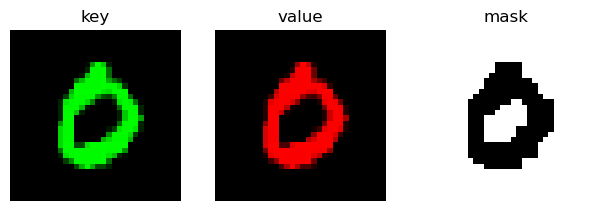

Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:02<00:00, 16.80it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.1472, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 10000/10000 [00:12<00:00, 777.5


Loss (orig, final): 1.2179887294769287 0.14718973636627197
L2 norm of weight change: 4.1482954025268555
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 26.51it/s]

Post-edit metrics: {'TP': array([448, 537, 520, 498, 452, 422, 436, 473, 454, 454]), 'TN': array([8317, 8376, 8213, 7561, 7788, 8237, 8376, 7919, 7885, 8022]), 'FPs': array([253,  39, 305, 979, 780, 421, 216, 603, 691, 519]), 'FNs': array([482, 548, 462, 462, 480, 420, 472, 505, 470, 505]), 'accuracy': 0.4941052631578947, 'per_class_accuracy': array([0.92263158, 0.93821053, 0.91926316, 0.84831579, 0.86736842,
       0.91147368, 0.92757895, 0.88336842, 0.87778947, 0.89221053]), 'per_class_accuracy_mean': 0.898821052631579, 'precision': array([0.63908702, 0.93229167, 0.63030303, 0.33716994, 0.36688312,
       0.50059312, 0.66871166, 0.43959108, 0.39650655, 0.46659815]), 'precision_mean': 0.5377735326051984, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.50118765, 0.48017621, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4939667149612541, 'predicted_class_distribution': array([ 701,  576,  825, 1477, 1232,  843,  652, 1076, 1145,  973]), 'f1

torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.int64


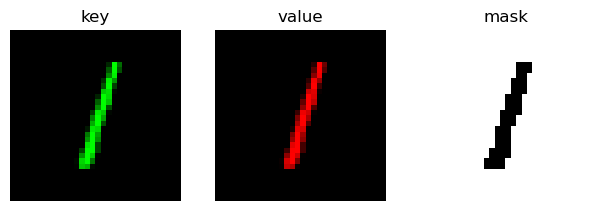

Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 26.09it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/debug/2_Spurious_MNIST-VGG_16/0317_154335/results/edit_idx_1/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0379, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 10000/10000 [00:12<00:00, 770.7


Loss (orig, final): 0.8326869010925293 0.03786785900592804
L2 norm of weight change: 3.537684917449951
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 26.40it/s]

Post-edit metrics: {'TP': array([448, 587, 519, 498, 452, 423, 436, 473, 454, 454]), 'TN': array([8330, 8374, 8213, 7554, 7783, 8246, 8368, 7961, 7881, 8034]), 'FPs': array([240,  41, 305, 986, 785, 412, 224, 561, 695, 507]), 'FNs': array([482, 498, 463, 462, 480, 419, 472, 505, 470, 505]), 'accuracy': 0.4993684210526316, 'per_class_accuracy': array([0.924     , 0.94326316, 0.91915789, 0.84757895, 0.86684211,
       0.91252632, 0.92673684, 0.88778947, 0.87736842, 0.89347368]), 'per_class_accuracy_mean': 0.8998736842105263, 'precision': array([0.65116279, 0.93471338, 0.62985437, 0.33557951, 0.36540016,
       0.50658683, 0.66060606, 0.45744681, 0.3951262 , 0.47242456]), 'precision_mean': 0.5408900661841299, 'recall': array([0.48172043, 0.54101382, 0.52851324, 0.51875   , 0.48497854,
       0.5023753 , 0.48017621, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.49859194174384525, 'predicted_class_distribution': array([ 688,  628,  824, 1484, 1237,  835,  660, 1034, 1149,  961]), '

torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.int64


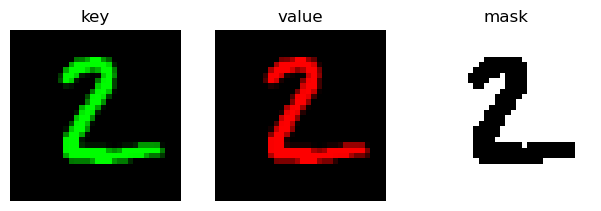

Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 26.12it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/debug/2_Spurious_MNIST-VGG_16/0317_154335/results/edit_idx_2/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0924, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 10000/10000 [00:12<00:00, 772.7


Loss (orig, final): 0.9827195405960083 0.0924491286277771
L2 norm of weight change: 2.972797155380249
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 26.01it/s]

Post-edit metrics: {'TP': array([448, 537, 521, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8327, 8375, 8208, 7561, 7785, 8241, 8369, 7918, 7889, 8024]), 'FPs': array([243,  40, 310, 979, 783, 417, 223, 604, 687, 517]), 'FNs': array([482, 548, 461, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.49442105263157893, 'per_class_accuracy': array([0.92368421, 0.93810526, 0.91884211, 0.84831579, 0.86705263,
       0.912     , 0.92694737, 0.88326316, 0.87821053, 0.89242105]), 'per_class_accuracy_mean': 0.898884210526316, 'precision': array([0.64833575, 0.93067591, 0.62695548, 0.33716994, 0.3659919 ,
       0.50357143, 0.66212121, 0.43918292, 0.39789658, 0.46755922]), 'precision_mean': 0.5379460327852051, 'recall': array([0.48172043, 0.49493088, 0.5305499 , 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.49429744495934014, 'predicted_class_distribution': array([ 691,  577,  831, 1477, 1235,  840,  660, 1077, 1141,  971]), '

torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.int64


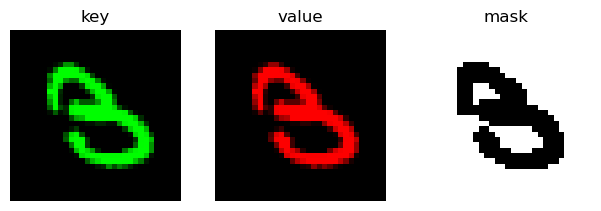

Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 26.12it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/debug/2_Spurious_MNIST-VGG_16/0317_154335/results/edit_idx_3/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0625, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 10000/10000 [00:12<00:00, 774.5


Loss (orig, final): 1.051389455795288 0.062487125396728516
L2 norm of weight change: 3.87650203704834
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.37it/s]

Post-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8324, 8373, 8216, 7563, 7780, 8241, 8364, 7916, 7895, 8024]), 'FPs': array([246,  42, 302, 977, 788, 417, 228, 606, 681, 517]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92336842, 0.93789474, 0.91957895, 0.84852632, 0.86652632,
       0.912     , 0.92642105, 0.88305263, 0.87884211, 0.89242105]), 'per_class_accuracy_mean': 0.898863157894737, 'precision': array([0.64553314, 0.92746114, 0.63260341, 0.33762712, 0.36451613,
       0.50357143, 0.65714286, 0.43836886, 0.4       , 0.46755922]), 'precision_mean': 0.5374383298180752, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 694,  579,  822, 1475, 1240,  840,  665, 1079, 1135,  971]), 'f1

Saved post-edit logits to saved/edit_2_Spurious_MNIST/method_eac/debug/2_Spurious_MNIST-VGG_16/0317_154335/results/edit_idx_3/models/post_edit_logits.pth
All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/debug/2_Spurious_MNIST-VGG_16/0317_154335/results/edit_idx_3/models
(0317_154453) Starting Trial 5/9...
torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.int64


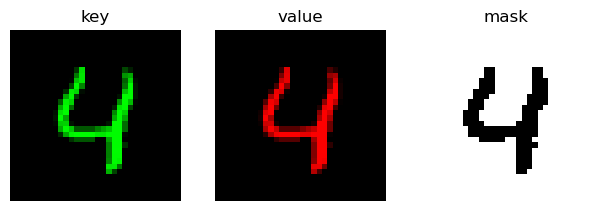

Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.90it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/debug/2_Spurious_MNIST-VGG_16/0317_154335/results/edit_idx_4/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.1026, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 10000/10000 [00:11<00:00, 845.6


Loss (orig, final): 1.193426489830017 0.10257043689489365
L2 norm of weight change: 4.47299337387085
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.97it/s]

Post-edit metrics: {'TP': array([448, 537, 520, 498, 453, 422, 437, 473, 454, 452]), 'TN': array([8327, 8375, 8205, 7551, 7797, 8243, 8354, 7915, 7881, 8046]), 'FPs': array([243,  40, 313, 989, 771, 415, 238, 607, 695, 495]), 'FNs': array([482, 548, 462, 462, 479, 420, 471, 505, 470, 507]), 'accuracy': 0.4941052631578947, 'per_class_accuracy': array([0.92368421, 0.93810526, 0.91842105, 0.84726316, 0.86842105,
       0.91210526, 0.92536842, 0.88294737, 0.87736842, 0.89452632]), 'per_class_accuracy_mean': 0.898821052631579, 'precision': array([0.64833575, 0.93067591, 0.6242497 , 0.33490249, 0.37009804,
       0.5041816 , 0.64740741, 0.43796296, 0.3951262 , 0.47729673]), 'precision_mean': 0.5370236777026024, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.4860515 ,
       0.50118765, 0.48127753, 0.48364008, 0.49134199, 0.4713243 ]), 'recall_mean': 0.49397559268366936, 'predicted_class_distribution': array([ 691,  577,  833, 1487, 1224,  837,  675, 1080, 1149,  947]), 'f

Saved post-edit logits to saved/edit_2_Spurious_MNIST/method_eac/debug/2_Spurious_MNIST-VGG_16/0317_154335/results/edit_idx_4/models/post_edit_logits.pth
All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/debug/2_Spurious_MNIST-VGG_16/0317_154335/results/edit_idx_4/models
(0317_154510) Starting Trial 6/9...
torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.int64


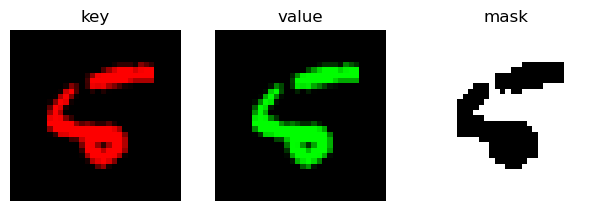

Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.87it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/debug/2_Spurious_MNIST-VGG_16/0317_154335/results/edit_idx_5/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0852, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 10000/10000 [00:12<00:00, 772.6


Loss (orig, final): 0.9471166729927063 0.08520843833684921
L2 norm of weight change: 2.8027238845825195
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 26.04it/s]

Post-edit metrics: {'TP': array([448, 537, 519, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8328, 8374, 8211, 7557, 7784, 8245, 8368, 7922, 7883, 8023]), 'FPs': array([242,  41, 307, 983, 784, 413, 224, 600, 693, 518]), 'FNs': array([482, 548, 463, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4942105263157895, 'per_class_accuracy': array([0.92378947, 0.938     , 0.91894737, 0.84789474, 0.86694737,
       0.91242105, 0.92684211, 0.88368421, 0.87757895, 0.89231579]), 'per_class_accuracy_mean': 0.898842105263158, 'precision': array([0.64927536, 0.92906574, 0.6283293 , 0.33625928, 0.36569579,
       0.50598086, 0.66111952, 0.44082013, 0.39581517, 0.46707819]), 'precision_mean': 0.5379439348145421, 'recall': array([0.48172043, 0.49493088, 0.52851324, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.49409377897156004, 'predicted_class_distribution': array([ 690,  578,  826, 1481, 1236,  836,  661, 1073, 1147,  972]), 'f

torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.int64


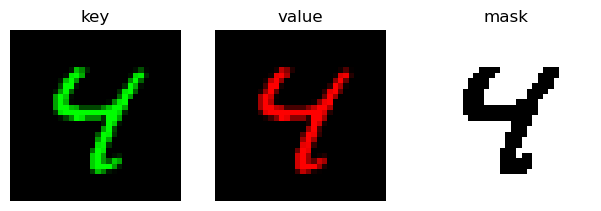

Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 26.01it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/debug/2_Spurious_MNIST-VGG_16/0317_154335/results/edit_idx_6/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.1101, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 10000/10000 [00:12<00:00, 778.7


Loss (orig, final): 1.1168369054794312 0.11012094467878342
L2 norm of weight change: 3.679229259490967
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.93it/s]

Post-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 474, 454, 454]), 'TN': array([8325, 8377, 8209, 7549, 7795, 8247, 8364, 7923, 7886, 8022]), 'FPs': array([245,  38, 309, 991, 773, 411, 228, 599, 690, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 504, 470, 505]), 'accuracy': 0.49442105263157893, 'per_class_accuracy': array([0.92347368, 0.93831579, 0.91884211, 0.84705263, 0.86810526,
       0.91263158, 0.92642105, 0.88389474, 0.87789474, 0.89221053]), 'per_class_accuracy_mean': 0.8988842105263158, 'precision': array([0.64646465, 0.93391304, 0.62726176, 0.33445265, 0.36897959,
       0.50719424, 0.65714286, 0.4417521 , 0.39685315, 0.46659815]), 'precision_mean': 0.5380612191300987, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48466258, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4942978614542026, 'predicted_class_distribution': array([ 693,  575,  829, 1489, 1225,  834,  665, 1073, 1144,  973]), '

Saved post-edit logits to saved/edit_2_Spurious_MNIST/method_eac/debug/2_Spurious_MNIST-VGG_16/0317_154335/results/edit_idx_6/models/post_edit_logits.pth
All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/debug/2_Spurious_MNIST-VGG_16/0317_154335/results/edit_idx_6/models
(0317_154545) Starting Trial 8/9...
torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.int64


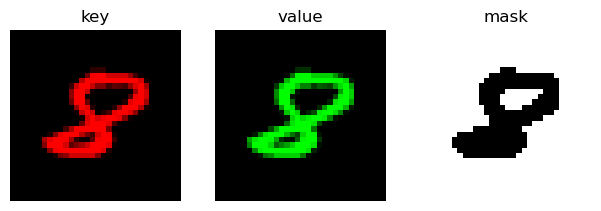

Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 26.41it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/debug/2_Spurious_MNIST-VGG_16/0317_154335/results/edit_idx_7/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.1193, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 10000/10000 [00:13<00:00, 768.5


Loss (orig, final): 1.0344688892364502 0.11931638419628143
L2 norm of weight change: 3.4739277362823486
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.70it/s]

Post-edit metrics: {'TP': array([448, 537, 518, 498, 452, 422, 438, 473, 454, 454]), 'TN': array([8334, 8373, 8217, 7556, 7773, 8247, 8369, 7924, 7882, 8019]), 'FPs': array([236,  42, 301, 984, 795, 411, 223, 598, 694, 522]), 'FNs': array([482, 548, 464, 462, 480, 420, 470, 505, 470, 505]), 'accuracy': 0.4941052631578947, 'per_class_accuracy': array([0.92442105, 0.93789474, 0.91947368, 0.84778947, 0.86578947,
       0.91252632, 0.92705263, 0.88389474, 0.87747368, 0.89189474]), 'per_class_accuracy_mean': 0.898821052631579, 'precision': array([0.65497076, 0.92746114, 0.63247863, 0.33603239, 0.36246993,
       0.50660264, 0.66263238, 0.44164332, 0.39547038, 0.46516393]), 'precision_mean': 0.5384925507042961, 'recall': array([0.48172043, 0.49493088, 0.52749491, 0.51875   , 0.48497854,
       0.50118765, 0.48237885, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.49398331329065465, 'predicted_class_distribution': array([ 684,  579,  819, 1482, 1247,  833,  661, 1071, 1148,  976]), 'f

Saved post-edit logits to saved/edit_2_Spurious_MNIST/method_eac/debug/2_Spurious_MNIST-VGG_16/0317_154335/results/edit_idx_7/models/post_edit_logits.pth
All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/debug/2_Spurious_MNIST-VGG_16/0317_154335/results/edit_idx_7/models
(0317_154603) Starting Trial 9/9...
torch.Size([1, 3, 32, 32]) torch.Size([1, 3, 32, 32])
torch.Size([1, 1, 32, 32])
torch.int64


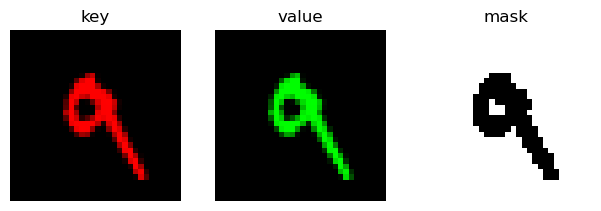

Created ModelWrapperSanturkar model with 33646666 trainable parameters
Restored weights from saved/train/2_Spurious_MNIST-VGG_16/0317_134644/models/model_best.pth
Using passed in data loader for validation.
Edit initialization arguments:
n_hold_out_per_class: 50
data_dir: saved/edit_data/{}/hold_out_{}
mask_path: None
image_size: [32, 32]
edit_idxs_file: edit_idxs.txt
edit_pool_file: test_hold_out_{}_eac.pt
---***---
Performing pre-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.58it/s]

Pre-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 454]), 'TN': array([8326, 8375, 8215, 7553, 7786, 8244, 8367, 7920, 7888, 8022]), 'FPs': array([244,  40, 303, 987, 782, 414, 225, 602, 688, 519]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 505]), 'accuracy': 0.4943157894736842, 'per_class_accuracy': array([0.92357895, 0.93810526, 0.91947368, 0.84747368, 0.86715789,
       0.91231579, 0.92673684, 0.88347368, 0.87810526, 0.89221053]), 'per_class_accuracy_mean': 0.8988631578947368, 'precision': array([0.64739884, 0.93067591, 0.63183475, 0.33535354, 0.36628849,
       0.50537634, 0.66012085, 0.44      , 0.39754816, 0.46659815]), 'precision_mean': 0.53811950339605, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.4734098 ]), 'recall_mean': 0.4941956119654501, 'predicted_class_distribution': array([ 692,  577,  823, 1485, 1234,  837,  662, 1075, 1142,  973]), 'f1':

Saved pre-edit logits to saved/edit_2_Spurious_MNIST/method_eac/debug/2_Spurious_MNIST-VGG_16/0317_154335/results/edit_idx_8/models/pre_edit_logits.pth
Created <class 'trainer.editor.EditorEAC'> editor.
Using passed in covariance data loader.
Looking for covariance matrix weights in cache/2_Spurious_MNIST_hold_out/vgg16_bn-12
Found precomputed cov matrices, returning...


tensor(0.0917, device='cuda:0', grad_fn=<DivBackward0>): 100%|█| 10000/10000 [00:11<00:00, 841.2


Loss (orig, final): 1.0784482955932617 0.09173238277435303
L2 norm of weight change: 3.019115686416626
Performing post-edit metric calculations on validation set.


100%|███████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 25.85it/s]

Post-edit metrics: {'TP': array([448, 537, 520, 498, 452, 423, 437, 473, 454, 455]), 'TN': array([8328, 8375, 8211, 7547, 7794, 8241, 8364, 7925, 7891, 8021]), 'FPs': array([242,  40, 307, 993, 774, 417, 228, 597, 685, 520]), 'FNs': array([482, 548, 462, 462, 480, 419, 471, 505, 470, 504]), 'accuracy': 0.49442105263157893, 'per_class_accuracy': array([0.92378947, 0.93810526, 0.91905263, 0.84684211, 0.868     ,
       0.912     , 0.92642105, 0.884     , 0.87842105, 0.89221053]), 'per_class_accuracy_mean': 0.8988842105263158, 'precision': array([0.64927536, 0.93067591, 0.62877872, 0.33400402, 0.36867863,
       0.50357143, 0.65714286, 0.44205607, 0.39859526, 0.46666667]), 'precision_mean': 0.5379444930437638, 'recall': array([0.48172043, 0.49493088, 0.52953157, 0.51875   , 0.48497854,
       0.5023753 , 0.48127753, 0.48364008, 0.49134199, 0.47445255]), 'recall_mean': 0.4942998872522071, 'predicted_class_distribution': array([ 690,  577,  827, 1491, 1226,  840,  665, 1070, 1139,  975]), '

Saved post-edit logits to saved/edit_2_Spurious_MNIST/method_eac/debug/2_Spurious_MNIST-VGG_16/0317_154335/results/edit_idx_8/models/post_edit_logits.pth
All metrics and KNN results can be found in saved/edit_2_Spurious_MNIST/method_eac/debug/2_Spurious_MNIST-VGG_16/0317_154335/results/edit_idx_8/models


In [10]:
# n_trials = len(edit_idxs)

# for idx, cur_edit_data in enumerate(edit_data):
#     # cur_edit_data is a tuple of (keys, values, labels)
#     informal_log("({}) Starting Trial {}/{}...".format(
#         datetime.now().strftime(r'%m%d_%H%M%S'), 
#         idx + 1, n_trials), 
#         progress_report_path)
#     run_id = os.path.join(timestamp, 'results', 'edit_idx_{}'.format(idx))
    
#     config = ConfigParser(config_dict, run_id=run_id)
    
#     trial_save_dir = config.save_dir
#     cur_trial_path = os.path.dirname(trial_save_dir)
#     informal_log(cur_trial_path, trial_paths_path)
#     edit_data_save_path = os.path.join(trial_save_dir, 'edit_data.pt')
#     # key_save_path = os.path.join(trial_save_dir, 'keys.pt')
#     # value_save_path =os.path.join(trial_save_dir, 'values.pt')
#     keys, values, labels = cur_edit_data
#     trial_edit_data = prepare_edit_data_eac(
#             keys=keys,
#             values=values,
#             labels=labels)
    
#     torch.save(trial_edit_data, edit_data_save_path)
#     print(trial_edit_data['masks'].dtype)
#     trial_edit_data['masks'] = trial_edit_data['masks'].to(torch.int32)
#     show_image_rows(
#         images=[np.concatenate([trial_edit_data['modified_imgs'], trial_edit_data['imgs'], trial_edit_data['masks'].repeat(1, 3, 1, 1)], axis=0)],
#         # images=[np.concatenate([trial_edit_data['modified_imgs'], trial_edit_data['imgs'], trial_edit_data['masks']], axis=0)],
#         image_titles=[['key', 'value', 'mask']])
#     edit_MNIST(
#         config=config,
#         test_data_loader=test_data_loader,
#         covariance_data_loader=covariance_data_loader,
#         edit_data=trial_edit_data,
#         do_analyze_knn=analyze_in_edit)
